In [1]:
import Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
import Rotations as rot
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc

  Activating project at `c:\Users\sesch\Git\Controller`
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

animate_cartpole (generic function with 1 method)

## Part B: Cart Pole Swingup (20 pts)

We are now going to solve for a cartpole swingup. The state for the cartpole is the following: 

$$ x = [p,\theta,\dot{p},\dot{\theta}]^T $$ 

Where $p$ and $\theta$ can be seen in the graphic `cartpole.png`.

<div>
<img src="attachment:cartpole.png" width="300"/>
</div>

where we start with the pole in the down position ($\theta = 0$), and we want to use the horizontal force on the cart to drive the pole to the up position ($\theta = \pi$).

$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{goal})^TQ(x_i - x_{goal}) + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}(x_N - x_{goal})^TQ_f(x_N - x_{goal})\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_N = x_{goal} \\ 
 & f_{hs}(x_i,x_{i+1},u_i,dt) = 0 \quad \text{for } i = 1,2,\ldots,N-1 \\
 & -10 \leq u_i \leq 10 \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$
 
 Where $x_{IC} = [0,0,0,0]$, and $x_{goal} = [0, \pi, 0, 0]$, and $f_{hs}(x_i,x_{i+1},u_i)$ is the implicit integrator residual for Hermite Simpson (see HW1Q1 to refresh on this). Note that while Zac used a first order hold (FOH) on the controls in class (meaning we linearly interpolate controls between time steps), we are using a zero-order hold (ZOH) in this assignment. This means that each control $u_i$ is held constant for the entirety of the timestep. 

In [16]:
# cartpole 
# function dynamics(params::NamedTuple, x::Vector, u)
#     # cartpole ODE, parametrized by params. 

#     # cartpole physical parameters 
#     mc, mp, ℓ = params.mc, params.mp, params.ℓ
#     g = 9.81
    
#     q = x[1:2]
#     qd = x[3:4]

#     s = sin(q[2])
#     c = cos(q[2])

#     H = [mc+mp mp*ℓ*c; mp*ℓ*c mp*ℓ^2]
#     C = [0 -mp*qd[2]*ℓ*s; 0 0]
#     G = [0, mp*g*ℓ*s]
#     B = [1, 0]

#     qdd = -H\(C*qd + G - B*u[1])
#     xdot = [qd;qdd]
#     return xdot 

# end


function dynamics(params::NamedTuple, x::Vector, u)
    mc, mp, ℓ, g = params.mc, params.mp, params.ℓ, params.g

    r = x[1] # cart position
    θ = x[2] # pole angle
    rd = x[3] # change in cart position
    θd = x[4] # change in pole angle
    F = u[1] # force applied to cart
    
    θdd = (g*sin(θ) + cos(θ) * ((-F - mp*ℓ*(θd^2) * sin(θ))/(mc + mp))) / (ℓ*(4/3 - (mp*(cos(θ)^2))/(mc + mp)))
    rdd = (F + mp*ℓ*((θd^2)*sin(θ) - θdd*cos(θ))) / (mc + mp)
  
    return [rd; θd; rdd; θdd]
end
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    ẋ1 = dynamics(params, x1, u)
    ẋ2 = dynamics(params, x2, u)
    xm = (1/2)*(x1 + x2) + (dt/8)*(ẋ1 - ẋ2)
    ẋm = dynamics(params, xm, u)
    x1 + (dt/6)*(ẋ1 + 4*ẋm + ẋ2) - x2
end

hermite_simpson (generic function with 1 method)

To solve this problem with IPOPT and `fmincon`, we are going to concatenate all of our $x$'s and $u$'s into one vector:

$$ Z = \begin{bmatrix}x_1 \\ u_1 \\ x_2 \\ u_2 \\ \vdots \\ x_{N-1} \\ u_{N-1} \\ x_N \end{bmatrix} \in \mathbb{R}^{N \cdot nx + (N-1)\cdot nu} $$ 

where $x \in \mathbb{R}^{nx}$ and $u \in \mathbb{R}^{nu}$. Below we will provide useful indexing guide in `create_idx` to help you deal with $Z$.

It is also worth noting that while there are inequality constraints present ($-10 \leq u_i \leq 10$), we do not need a specific `inequality_constraints` function as an input to `fmincon` since these are just bounds on the primal ($Z$) variable. You should use primal bounds in `fmincon` to capture these constraints.  

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   294752
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      604
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      120
                     variables with only upper bounds:        0
Total number of equality constraints.

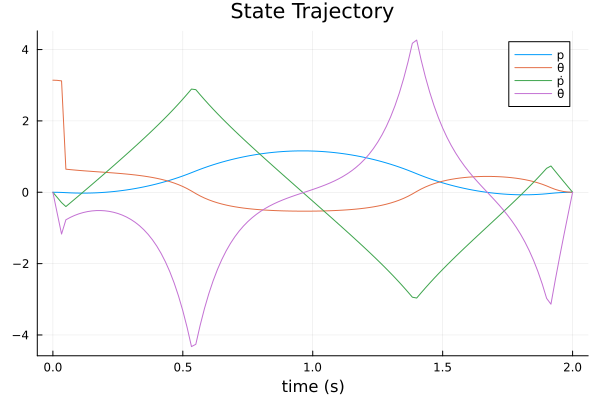

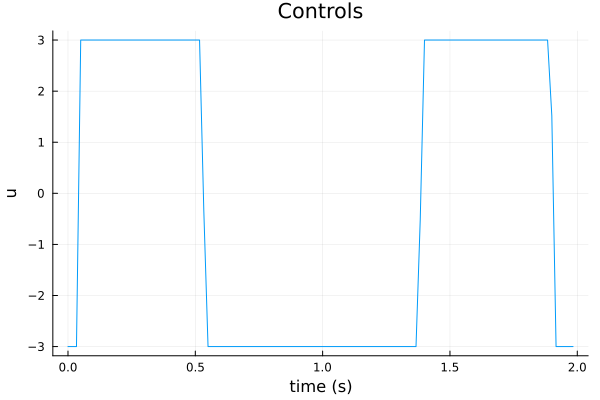

In [24]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx, nu=nu, N=N, nz=nz, nc=nc, x=x, u=u, c=c)
end

function cartpole_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += 0.5*(xi - xg)'*Q*(xi - xg)
        J += 0.5*ui'*R*ui 
    end
    
    xn = Z[idx.x[N]]
    J += 0.5*(xn - xg)'*Qf*(xn - xg)
        
    return J 
end

function cartpole_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c 
end

function cartpole_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    [
        Z[idx.x[1]] - xic;
        Z[idx.x[N]] - xg;
        cartpole_dynamics_constraints(params, Z)
    ]
end


function solve_cartpole_swingup(mc, mp, ℓ, g; verbose=true)
    
    # problem size 
    nx = 4 
    nu = 1 
    dt = 1/60
    tf = 2.0
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    # Q = collect(Diagonal([500; 40; 30; 100]))
    Q = 1*diagm(ones(nx))
    R = 10*diagm(ones(nu))
    Qf = 10*Q
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    xic = [0, pi, 0, 0] # for vertical = 0 radians
    xg = [0, 0, 0, 0] # for vertical = 0 radians
    # xic = [0, 0, 0, 0] # for vertical = π radians
    # xg = [0, pi, 0, 0] # for vertical = π radians

    
    # load all useful things into params 
    params = (Q=Q, R=R, Qf=Qf, xic=xic, xg=xg, dt=dt, N=N, idx=idx, mc=mc, mp=mp, ℓ=ℓ, g=g)

    # primal bounds 
    x_l = -Inf*ones(idx.nz)
    x_u =  Inf*ones(idx.nz)
    
    # bounds on u 
    # u_min = -1.0
    # u_max =  1.0 
    u_min = -3.0
    u_max =  3.0 
    
    for i = 1:(N-1)
        x_l[idx.u[i]] .= u_min 
        x_u[idx.u[i]] .= u_max 
    end
    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess
    z0 = 0.001*randn(idx.nz)
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
#     diff_type = :finite
    
    Z = fmincon(cartpole_cost, cartpole_equality_constraint, inequality_constraint,
                x_l, x_u, c_l, c_u, z0, params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    # pull the X and U solutions out of Z
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params
end

include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

# For short pole
mass_cart = 0.3 # mass of the cart (kg)
mass_pole = 0.177 # mass of the pole (kg)
ℓ = 0.184 # distance to the center of mass (meters)

g = 9.81


# @testset "cartpole swingup" begin

X, U, t_vec, params_dircol = solve_cartpole_swingup(mass_cart, mass_pole, ℓ, g; verbose=true)

# --------------testing------------------
# @test isapprox(X[1], [0,pi,0,0], atol = 1e-4)
# @test isapprox(X[end], zeros(4), atol = 1e-4)
Xm = hcat(X...)
Um = hcat(U...)

# --------------plotting-----------------
display(plot(t_vec, Xm', label = ["p" "θ" "ṗ" "θ̇"], xlabel = "time (s)", title = "State Trajectory"))
display(plot(t_vec[1:end-1], Um', label="", xlabel = "time (s)", ylabel = "u", title = "Controls"))

# meshcat animation
# display(animate_cartpole(X, 1/60))

# end


In [100]:
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

animate_cartpole (generic function with 1 method)

In [17]:
vis = mc.Visualizer()
cartpole = Cartpole(ℓ, true)
create_cartpole!(vis, cartpole)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\sesch\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat Visualizer with path /meshcat/b at http://127.0.0.1:8700

In [23]:
anim = mc.Animation(floor(Int,60))
for k = 1:length(X)
    mc.atframe(anim, k) do
        update_cartpole_transform!(vis, X[k], cartpole)
    end
end
mc.setanimation!(vis, anim)

## Part C: Track DIRCOL Solution (5 pts)

Now, similar to HW2 Q2 Part C, we are taking a solution $X$ and $U$ from DIRCOL, and we are going to track the trajectory with TVLQR to account for model mismatch. While we used hermite-simpson integration for the dynamics constraints in DIRCOL, we are going to use RK4 for this simulation. Remember to clamp your control to be within the control bounds. 

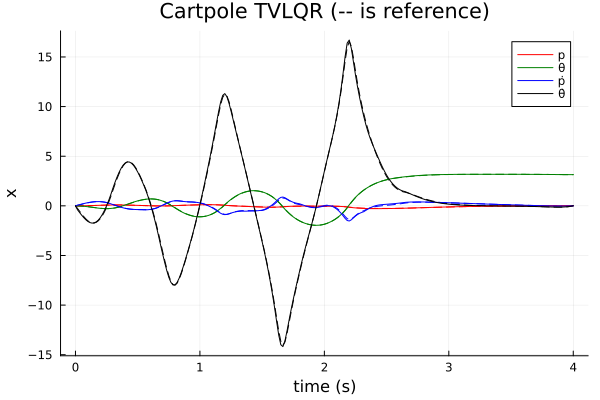

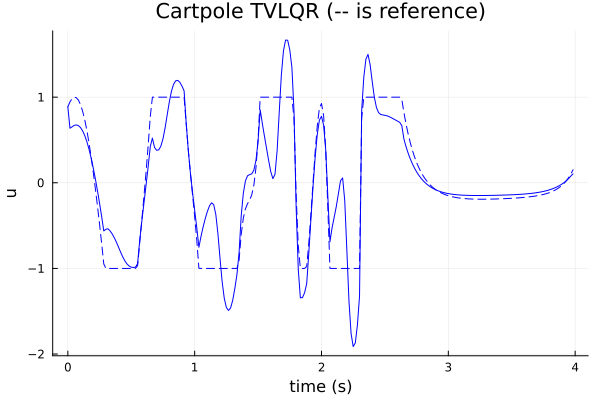

In [200]:
function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end
function tvlqr(As::Vector{Matrix{Float64}},       # vector of A matrices 
               Bs::Vector{Matrix{Float64}},       # vector of B matrices 
               Q::Matrix,               # cost matrix Q 
               R::Matrix,               # cost matrix R 
               Qf::Matrix               # cost matrix Qf 
               )::Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}} # return two vectors of matrices 
    
    # make sure A and B are same length 
    N = length(As) + 1 
    @assert length(Bs) == (N - 1)
    
    # get size of x and u from B 
    nx, nu = size(Bs[1])
    
    # instantiate S and K 
    S = [zeros(nx,nx) for i = 1:N]
    K = [zeros(nu,nx) for i = 1:N-1]
    
    # initialize S[N] with Qf 
    S[N] = deepcopy(Qf)
    
    # Ricatti 
    for k = (N-1):(-1):1 
        A = As[k]
        B = Bs[k]
        K[k] = (R + B'*S[k+1]*B)\(B'*S[k+1]*A)
        S[k] = Q + K[k]'*R*K[k] + (A - B*K[k])'S[k+1]*(A - B*K[k])
    end
    
    return S, K 
end

# @testset "track cartpole swingup with TVLQR" begin 

# X_dircol, U_dircol, t_vec, params_dircol = solve_cartpole_swingup(mass_cart, mass_pole, ℓ, g; verbose = false)

X_dircol, U_dircol = X, U

N = length(X_dircol)
dt = params_dircol.dt 
x0 = X_dircol[1]

As = [ForwardDiff.jacobian(_x -> rk4(params_dircol, _x, U_dircol[i], dt), X_dircol[i]) for i = 1:(N-1)]
Bs = [ForwardDiff.jacobian(_u -> rk4(params_dircol, X_dircol[i], _u, dt), U_dircol[i]) for i = 1:(N-1)]

Q = diagm([1,1,.05,.1])
Qf = 100*Q
R = 0.01*diagm(ones(1))

S, K = tvlqr(As, Bs, Q, R, Qf)

# simulation
Xsim = [zeros(4) for i = 1:N]
Usim = [zeros(1) for i = 1:(N-1)]
Xsim[1] = 1*x0 

# here are the real parameters (different than the one we used for DIRCOL)
# this model mismatch is what's going to require the TVLQR controller to track
# the trajectory successfully. 
# params_real = (mc=0.3, mp=0.177, ℓ=0.184)
params_real = (mc=0.2, mp=0.170, ℓ=0.184)

for i = 1:(N-1)
    Δx = Xsim[i] - X_dircol[i]
    Δu = -K[i]*Δx
    Usim[i] = clamp.(U_dircol[i] + Δu, -2, 2)
    Xsim[i+1] = rk4(params_real, Xsim[i], Usim[i], dt) 
end


# -----------------testing-----------------------
xn = Xsim[N]
# @test norm(xn) > 0
# @test 1e-6 < norm(xn - X_dircol[end]) < .8
# @test abs(abs(rad2deg(xn[2])) - 180) < 5 # within 5 degrees 
# @test maximum(norm.(Usim, Inf)) <= (10 + 1e-3)

# -----------------plotting----------------------
Xm = hcat(Xsim...)
Xbarm = hcat(X_dircol...)
plot(t_vec,Xbarm',ls=:dash, label = "",lc = [:red :green :blue :black])
display(plot!(t_vec,Xm',title = "Cartpole TVLQR (-- is reference)",
                xlabel = "time (s)", ylabel = "x",
                label = ["p" "θ" "ṗ" "θ̇"],lc = [:red :green :blue :black]))

Um = hcat(Usim...)
Ubarm = hcat(U_dircol...)
plot(t_vec[1:end-1],Ubarm',ls=:dash,lc = :blue, label = "")
display(plot!(t_vec[1:end-1],Um',title = "Cartpole TVLQR (-- is reference)",
                xlabel = "time (s)", ylabel = "u",lc = :blue, label = ""))

# # ----------------animate------------------------
# display(animate_cartpole(Xsim, .05))

# end

In [201]:
anim = mc.Animation(floor(Int, 60))
for k = 1:length(X)
    mc.atframe(anim, k) do
        update_cartpole_transform!(vis, Xsim[k], cartpole)
    end
end
mc.setanimation!(vis, anim)